# NLP

In [71]:
import re
from string import punctuation, digits, ascii_lowercase

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import (train_test_split,cross_val_score,
                                      StratifiedShuffleSplit)
from sklearn.dummy import DummyClassifier
                                      
%matplotlib inline

In [9]:
reviews = pd.read_csv('yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.csv')

In [123]:
reviews.groupby(['stars']).count()

,user_id,review_id,text,votes.cool,business_id,votes.funny,date,type,votes.useful
stars,,,,,,,,,
1,260492,260492,260492,260492,260492,260492,260492,260492,260492
2,190048,190048,190048,190048,190048,190048,190048,190048,190048
3,282115,282115,282115,282115,282115,282115,282115,282115,282115
4,591618,591618,591618,591618,591618,591618,591618,591618,591618
5,900940,900940,900940,900940,900940,900940,900940,900940,900940


In [124]:
a = [260492,190048,282115,591618,900940]

In [127]:
[float(i)/sum(a) for i in a]

[0.11706384961799163,
 0.0854066554527589,
 0.1267811216274577,
 0.2658702784857,
 0.40487809481609177]

In [10]:
samp = reviews.sample(n=10000)

Define lists of escape sequences, digits, stopwords to use for parseing. Also defines the type of stemming to be used. 

In [11]:
escapes = ''.join([chr(char) for char in range(1, 32)])
removeables = escapes + digits 
stops = [str(word) for word in stopwords.words('english')] + list(ascii_lowercase)
sno = nltk.stem.SnowballStemmer('english')

Create function to process the text and then use it to make a new coloumn in the dataframe where all texted has been processed. 

In [12]:
def parse_text(text, stem=True):
    ''' This function takes a review string and removes all escape sequences,
        digits, punctuation, http links, and stop words. Furthermore, every
        word in the string will be stemmed using nltk's snowball stemmer.
        Every word is also transformed to be lowercase.'''
    
    text = re.sub(r"http\S+", " ", text)
    regex = re.compile('[%s]' % re.escape(punctuation))
    text = regex.sub(' ', text)
    text = text.translate(None, removeables)
    text = text.decode('utf8')
    if stem == True:
        text = ' '.join([sno.stem(word.lower()) for word in text.split() if word.lower() not in set(stops)])
    else:
        text = ' '.join([word.lower() for word in text.split() if word.lower() not in set(stops)])
    return text

In [13]:
samp['parsed_text']=samp.text.apply(parse_text,stem=False)

### Bag of words, tf-idf vectorization
Create the bag of words representation. Find counts of each word in document and in whole courpus. Then create the tfidf representation. Worth also considering binary count vecorizing, supposed to work better for smaller sample sets.

In [14]:
corpus = samp.parsed_text.tolist()

In [15]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(corpus)

In [16]:
words = count_vect.get_feature_names()

In [ ]:
# len(words) = 20197

### Exploring count data

In [17]:
stars = samp.stars.reshape(10000,1)
counts = X_counts.toarray()

In [18]:
C = np.concatenate((stars,counts),axis=1)

In [19]:
df = pd.DataFrame(C)

In [20]:
df.columns = ['star_rating'] + words

In [21]:
star_counts = dict(samp.stars.value_counts())

In [22]:
groups = df.groupby(['star_rating']).sum().T

In [23]:
for k,v in star_counts.items():
    groups[k] = groups[k]/v

In [34]:
groups.sort([5],ascending=False).head(30)

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


star_rating,1,2,3,4,5
great,0.114424,0.237089,0.353175,0.539394,0.583479
place,0.500403,0.647887,0.584921,0.574242,0.496132
food,0.534247,0.793427,0.680159,0.562121,0.436736
good,0.280419,0.637324,0.867460,0.721970,0.389069
time,0.445608,0.444836,0.367460,0.307197,0.329174
service,0.438356,0.484742,0.353175,0.313258,0.316446
like,0.402901,0.610329,0.541270,0.430682,0.309209
one,0.467365,0.471831,0.383333,0.358333,0.284253
best,0.064464,0.123239,0.134127,0.158712,0.282256
love,0.044319,0.116197,0.114286,0.167045,0.273272


### TFIDF

In [35]:
vectorizer = TfidfVectorizer(min_df=1)
X_tfidf = vectorizer.fit_transform(corpus)

In [36]:
tfidfs = X_tfidf.toarray()
T = np.concatenate((stars,tfidfs),axis=1)
df_tfidf = pd.DataFrame(T)
df_tfidf.columns = ['star_rating'] + words
tfidf_groups = df.groupby(['star_rating']).sum().T


In [28]:
for k,v in star_counts.items():
    tfidf_groups[k] = tfidf_groups[k]/v

In [37]:
y = np.array(samp.stars.tolist())

### test 

In [129]:
test = df[['great','good','service']]

In [130]:
test.shape

(10000, 3)

In [131]:
X_train, X_test, y_train, y_test = train_test_split(test,y,test_size=.30,
                                                    stratify=y)

In [146]:
mnb = MultinomialNB(fit_prior=False).fit(X_train,y_train)

In [147]:
probs = mnb.feature_log_prob_

In [148]:
preds = mnb.predict(X_test)

In [149]:
mnb.score(X_test,y_test)

0.29299999999999998

In [152]:
print y_test[15:25]
print preds [15:25]
print probs
print np.exp(mnb.class_log_prior_)
print test[15:25]


[5 4 5 5 2 4 4 5 1 3]
[5 1 3 1 1 1 1 5 1 1]
[[-1.91163675 -1.13265813 -0.63490459]
 [-1.74070981 -0.75727978 -1.03376931]
 [-1.47310856 -0.5921345  -1.52490007]
 [-1.06594395 -0.76960167 -1.64817945]
 [-0.80245211 -1.16474505 -1.42807809]]
[ 0.2  0.2  0.2  0.2  0.2]
    great  good  service
15      0     1        1
16      0     0        0
17      0     0        0
18      1     1        0
19      2     0        0
20      0     0        0
21      0     0        0
22      1     1        0
23      0     1        0
24      0     0        0


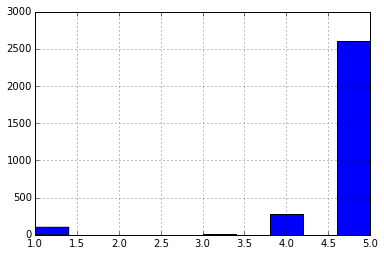

In [135]:
pd.Series(preds).hist()

### inspect the errors. 

see where the model is getting it wrong. look at the actual text that is giving rise to the incorrect predictions, and see if you can get some intuitions about why it is getting it wrong. you can then possibly create new features to capture these effects. 

additionally, it would be very interesting to cluster words based on their characteristics fns. this should create a cluster for pos, neg, neural, and avergae. would be very interesting to present. further it could help smooth out the signal if instead of count vecotrizing based on if word exists, but rather if word in cluster exists. could just clean up the analysis.

also, think about correcting the prior using the prior from the complete data set, instead of just the sample. 

### Train-Test split

Need to split the dataset into train and test, then use cross val to traing the classifier.

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_counts,y,test_size=.30,
                                                    stratify=y)

In [ ]:
sss = StratifiedShuffleSplit(y_train, 5, test_size=0.3, random_state=0)

# Training a classifier

### true values

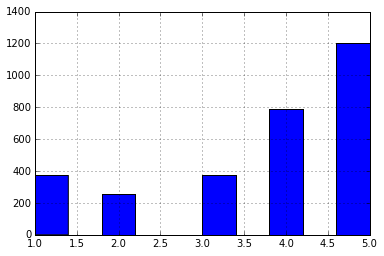

In [110]:
pd.Series(y_test).hist()

### baseline model - random

In [76]:
dummy = DummyClassifier(strategy='stratified', random_state=1) 

In [77]:
dummy.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=1, strategy='stratified')

In [80]:
preds = dummy.predict(X_test)

In [81]:
dummy.score(X_test,y_test)

0.26700000000000002

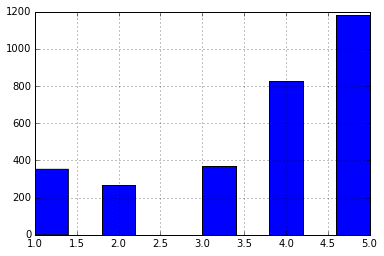

In [79]:
pd.Series(preds).hist()

### baseline - highest frequency

In [100]:
dummy = DummyClassifier(strategy='most_frequent', random_state=1) 

In [101]:
dummy.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=1, strategy='most_frequent')

In [102]:
preds = dummy.predict(X_test)

In [103]:
dummy.score(X_test,y_test)

0.40066666666666667

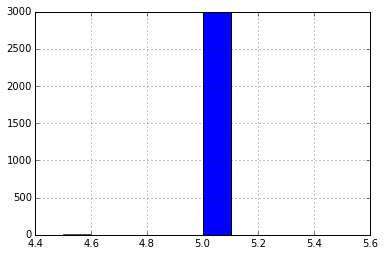

In [104]:
pd.Series(preds).hist()

### informed prior

In [112]:
mnb = MultinomialNB(fit_prior=True).fit(X_train,y_train)

In [113]:
np.exp(mnb.class_log_prior_)

array([ 0.12414286,  0.08514286,  0.126     ,  0.264     ,  0.40071429])

In [114]:
preds = mnb.predict(X_test)

In [115]:
mnb.score(X_test,y_test)

0.54000000000000004

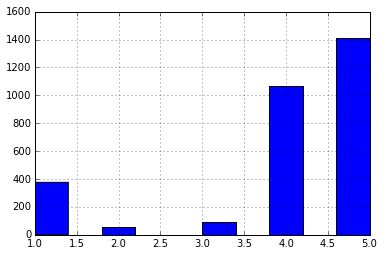

In [116]:
pd.Series(preds).hist()

### uniformative prior

In [117]:
mnb = MultinomialNB(fit_prior=False).fit(X_train,y_train)

In [106]:
np.exp(mnb.class_log_prior_)

array([ 0.2,  0.2,  0.2,  0.2,  0.2])

In [118]:
preds = mnb.predict(X_test)

In [119]:
mnb.score(X_test,y_test)

0.54366666666666663

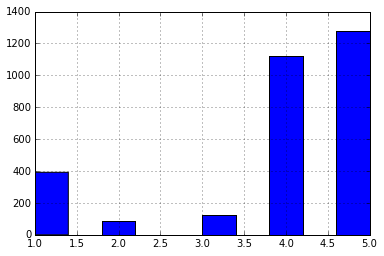

In [120]:
pd.Series(preds).hist()

### Accuracy Metrics

importnatn to consider what is the best accuracy measure to use to test results. notice that star rating is a ordered 